## Storage Losses
Purpose: to calculate losses in battery capacity while held in Montana over the Summer 2024

**Important Values and Information:**
* 200 kOhm resistor ladder used.
* Considering pack voltage, what is the current pulled from the batteries and what is the resulting voltage loss.
* Using the known final SoC and voltage of the pack from Endurance, how much has the voltage dropped since then?

In [1]:
# Load signal dict data to observe final voltages and SoC from pack at end of endurance

import pickle

infile = "../../LapSim_Validation/signal_dict.pkl"

with open(infile, "rb") as file:
    signal_dict = pickle.load(file)

In [2]:
# Create a class to better upload and update the data, hopefully making it easier to plot
import numpy as np
import datetime

class nestedDict:
    def __init__(self, inputDict, inputKey):
        self.name = inputKey
        self.date_time = inputDict[inputKey]["Time"]
        self.duration = np.array(inputDict[inputKey]["Duration"])
        self.value = np.array(inputDict[inputKey]["Value"])
        self.unit = inputDict[inputKey]["Unit"]

# Plotting Function
import matplotlib.pyplot as plt

def plotVsTime(inputs, y_unit, title, xlimits=[None, None], ylimits=[None, None]):
    for i in range(0, len(inputs)):
        plt.plot(inputs[i].duration, inputs[i].value, label=inputs[i].name, linewidth=1)

    plt.legend()
    plt.grid(True)
    plt.title(title)
    plt.xlabel("Duration (s)")
    plt.ylabel(y_unit)
    plt.xlim(xlimits)
    plt.ylim(ylimits)

    if " " in title:
        title = title.replace(" ", "_")
    filePath = "plots/" + title + ".png"
    plt.savefig(filePath)
    plt.show()

Pack Voltage:
* Steady voltage at end of endurance race is 319.75 V

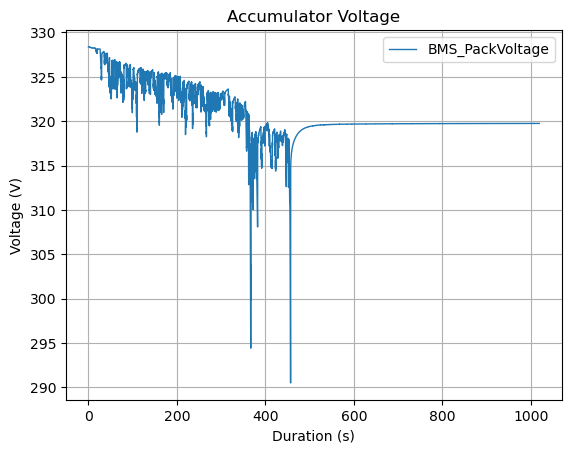

319.75

In [3]:
# Plot data about pack voltage
# accVoltage = nestedDict(signal_dict, "BMS_TractiveSystemVoltage")       # This tells us that the TS Voltage is the one measured while current is pulled through battery
accVoltage2 = nestedDict(signal_dict, "BMS_PackVoltage")

plotVsTime([accVoltage2], "Voltage (V)", "Accumulator Voltage")

accVoltage2.value[-1]

State of Charge:
* Steady SoC at end of the endurance race is 75.5%

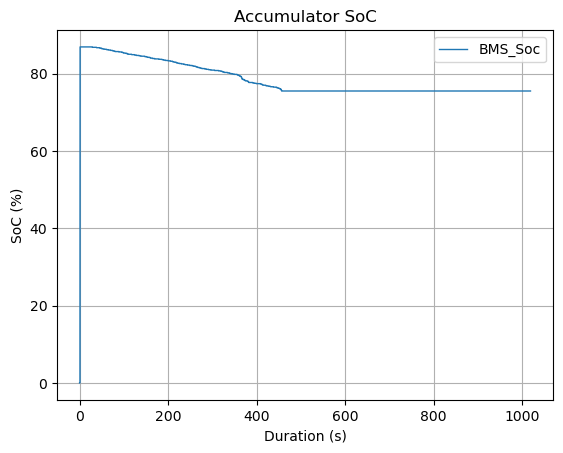

75.5

In [4]:
# Plot SoC Data
SoC = nestedDict(signal_dict, "BMS_Soc")

plotVsTime([SoC], "SoC (%)", "Accumulator SoC")

SoC.value[-1]

Calculations:
* 200 kOhm resistance in each segment.
* 319.75 V at end of endurance race.
* 75.5% SoC at end of endurance race.

What do I still need?
* SoC curves for Melasta cells to determine voltage loss over two months.

Looking at the Melasta curves that Edwin created, and knowing that the current draw is pretty much negligible... There should be little difference in the overall voltage.

Determine what the capacity loss is (approximately) based on the current pull from the battery.

In [49]:
# Initial series element voltage:
pack_voltage = 319.75
se_voltage = 319.75 / 80
segment_voltage = 319.75 / 5

# Current from battery
resistance = 200 * 10**3 # Ohms
current = segment_voltage / resistance

CRate = current / 17.7 # 0.0018 C (VERY LOW)

In [50]:
import datetime

# Endurance Day: June 15
# Driving Home Day: August 27

firstday = datetime.datetime.strptime("06-15", "%m-%d")
lastday = datetime.datetime.strptime("08-27", "%m-%d")

dayInterval = lastday - firstday  # 73 days have passed
dayInterval.days

# Capacity Loss over 2 months assuming constant voltage:
hours = dayInterval.days * 24     # hours in 73 days

# Initial Capacity using SoC
final_SoC = 75.5 / 100
capacity = 17.7 * final_SoC

# Capacity Loss
capacity_lost = hours * current
capacity_lost

0.560202

Now, I know that we need to look at this based on changing state of charge

Step 1: Get SoC vs. Voltage Information from Edwin's Cell Characterization

In [7]:
import pandas as pd

infile = "Discharge_0.5C.csv"

soc_voltage = pd.read_csv(infile, header=0)

melasta_SoC = soc_voltage.loc[:,"SoC"].to_numpy(dtype=float)
melasta_voltage = soc_voltage.loc[:,"Voltage"].to_numpy(dtype=float)
# Always using the 0.5C because current will never be greater than this

# Check for proper sorting of the data
for i in range(0, len(melasta_SoC)-1):
    if melasta_SoC[i+1] > melasta_SoC[i]:
        print("Incontinuities in dataset order.")

# Ok - so no issues in data ordering...

Step 2: Iterate to determine final voltage

In [47]:
import numpy as np

# Set up all required constants
timeSeries = np.linspace(0, hours, 10000)   # time series vector to iterate over
dt = timeSeries[1] - timeSeries[0]          # hours
resistance = 200 * 10**3                    # Ohms

# Set up vectors
se_voltage = np.zeros(len(timeSeries))
capacity = np.zeros(len(timeSeries))
current = np.zeros(len(timeSeries))
SoC = np.zeros(len(timeSeries))
capacity_loss = np.zeros(len(timeSeries))

se_voltage[0] = 319.75 / 5                  # V
SoC[0] = 75.5                               # %
capacity[0] = 17.7 * SoC[0] / 100           # Ah
index = 0                                   # Resetting variables

# Conduct iteration
for i in range(0, len(timeSeries) - 1):
    current[i] = se_voltage[i] / resistance     # Calculate current draw

    capacity_loss[i] = dt * current[i]          # Capacity_loss (Ah), since 'dt' is in units of hours

    capacity[i+1] = capacity[i] - capacity_loss[i] # New capacity

    SoC[i+1] = capacity[i+1] / 17.7 * 100       # New SoC

    index = np.searchsorted(-melasta_SoC, -SoC[i+1]) # Index of closest SoC location in lookup table (negated to deal with descending array)

    se_voltage[i+1] = 16 * melasta_voltage[index]  # to represent the 16 series elements

capacity_loss[-1] = capacity_loss[i]
current[-1] = current[i]

capacity_loss[0] = capacity_loss[1]
se_voltage[0] = se_voltage[1]
current[0] = current[1]

cellVoltage = se_voltage / 16

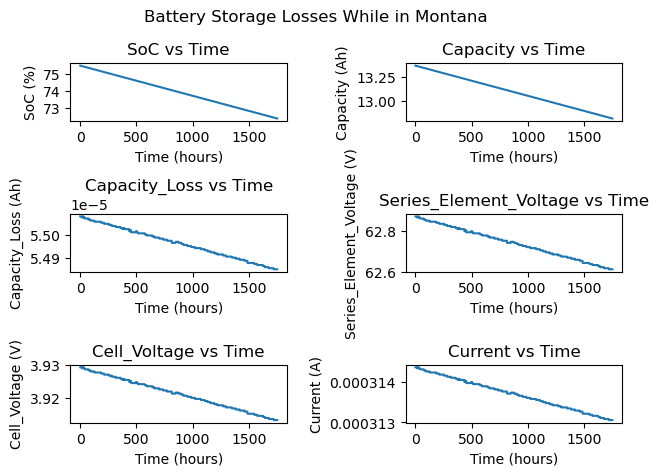

In [48]:
# Plot results
import matplotlib.pyplot as plt

fig, ax = plt.subplots(3, 2)
labels = ["SoC (%)", "Capacity (Ah)", "Capacity_Loss (Ah)", "Series_Element_Voltage (V)", "Cell_Voltage (V)", "Current (A)"]
values = [SoC, capacity, capacity_loss, se_voltage, cellVoltage, current]

i = 0
row = 0
col = 0

for name, data in zip(labels, values):
    
    ax[row][col].plot(timeSeries, data, label=name)
    ax[row][col].set_xlabel("Time (hours)")
    ax[row][col].set_ylabel(name)
    ax[row][col].set_title(name.split(" ")[0] + " vs Time")

    if i % 2 == 1:
        row = row + 1
        col = 0
    else:
        col = 1

    i = i+1

fig.suptitle("Battery Storage Losses While in Montana")
fig.tight_layout(pad=1)
plt.savefig("StorageLosses.png")
plt.show()